# OCT Dataset Inspection Notebook

**Purpose:** Quickly inspect and summarise a retinal OCT dataset for classification tasks (e.g., NORMAL / CNV / DME / DRUSEN).

**What this notebook does:**
- Detect class folders and count images
- Build a metadata table (path, class, width, height, file size)
- Plot class balance and image size distribution (matplotlib only)
- Create a simple montage image preview (single-plot)
- Export a `labels.csv` ready for PyTorch training (split by patient if available)

**Instructions:**
1. Set `DATA_ROOT` below to your dataset path (parent folder containing class subfolders).
2. (Optional) Adjust `CLASS_DIRS` if your class folders differ.
3. Run each cell top-to-bottom.

> Note: This notebook intentionally avoids seaborn and subplots. Each figure is a single-plot matplotlib figure.

In [1]:
import os, sys, csv, math, random, hashlib
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
DATA_ROOT = '/Volumes/Extreme SSD/CellData/OCT'
# If None, class directories will be auto-detected as immediate subfolders of DATA_ROOT.
CLASS_DIRS = None  # e.g., ["CNV", "DME", "DRUSEN", "NORMAL"]

# Allowed image extensions
IMG_EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

# Set a random seed for reproducibility
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

DATA_ROOT = Path(DATA_ROOT)
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"

if CLASS_DIRS is None:
    CLASS_DIRS = [p.name for p in DATA_ROOT.iterdir() if p.is_dir()]
CLASS_DIRS = sorted(CLASS_DIRS)
print("Detected classes:", CLASS_DIRS)

Detected classes: ['test', 'train', 'val']


In [2]:
from pathlib import Path
import pandas as pd
from PIL import Image

# ---- 1) POINT THIS TO YOUR REAL MAC PATH ----
DATA_ROOT = Path("/Volumes/Extreme SSD/CellData/OCT")  # try this first
if not DATA_ROOT.exists():
    DATA_ROOT = Path("/Volumes/ExtremeSSD/CellData/OCT")  # fallback if the volume name has no space
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"

# ---- 2) DEFINE SPLITS + CLASSES ----
SUBSETS    = ["train", "val", "test"]         # your folder layout
CLASS_DIRS = ["CNV", "DME", "DRUSEN", "NORMAL"]
ALLOW_EXT  = {".png",".jpg",".jpeg",".tif",".tiff",".bmp"}

rows = []
bad = 0
for split in SUBSETS:
    for cls in CLASS_DIRS:
        cdir = DATA_ROOT / split / cls
        if not cdir.exists():
            print(f"[WARN] missing: {cdir}")
            continue
        for fp in cdir.rglob("*"):
            # skip directories, hidden Apple "._" files, and non-images
            if fp.is_dir(): 
                continue
            name = fp.name
            if name.startswith("._"):
                continue
            if fp.suffix.lower() not in ALLOW_EXT:
                continue
            try:
                with Image.open(fp) as im:
                    w, h = im.size
            except Exception as e:
                bad += 1
                if bad < 10:
                    print(f"[SKIP] {fp}: {e}")
                continue
            rows.append({
                "patient_id": fp.stem.split("-")[0] or "na",  # simple heuristic
                "path": str(fp),
                "label_name": cls,
                "split": split,
                "width": w,
                "height": h,
                "filesize": fp.stat().st_size,
            })

meta = pd.DataFrame(rows)
assert len(meta) > 0, f"No images found under {DATA_ROOT}. Check split/class names and extensions."
print("Total images:", len(meta))
print(meta.groupby(["split","label_name"]).size())

# ---- 3) MAKE NUMERIC LABELS + SAVE CSV ----
label_to_id = {c:i for i,c in enumerate(CLASS_DIRS)}
meta["label"] = meta["label_name"].map(label_to_id).astype(int)
labels = meta[["patient_id","path","label","split"]].copy()

out_csv = Path.home() / "Documents" / "OCT_Project" / "labels.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
labels.to_csv(out_csv, index=False)
print("✅ Wrote:", out_csv)

Total images: 109309
split  label_name
test   CNV             250
       DME             250
       DRUSEN          250
       NORMAL          250
train  CNV           31476
       DME            9646
       DRUSEN         7324
       NORMAL        43469
val    CNV            5729
       DME            1702
       DRUSEN         1292
       NORMAL         7671
dtype: int64
✅ Wrote: /Users/diarmuidlenihan/Documents/OCT_Project/labels.csv


label_name
CNV       37455
DME       11598
DRUSEN     8866
NORMAL    51390
Name: count, dtype: int64


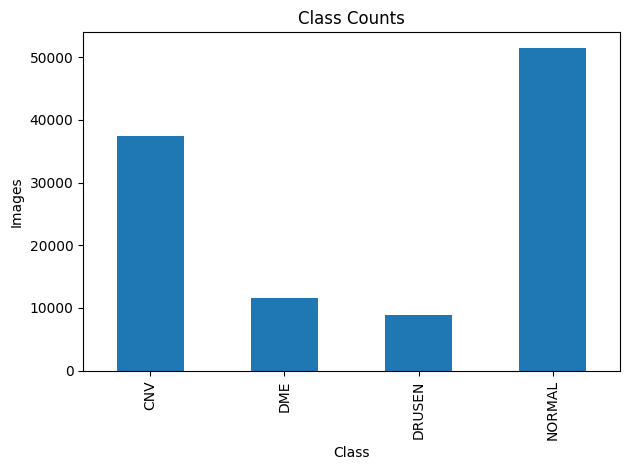

In [3]:
# Class counts
class_counts = meta['label_name'].value_counts().sort_index()
print(class_counts)

# Plot class balance (single plot)
plt.figure()
class_counts.plot(kind='bar')
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('Images')
plt.tight_layout()
plt.show()

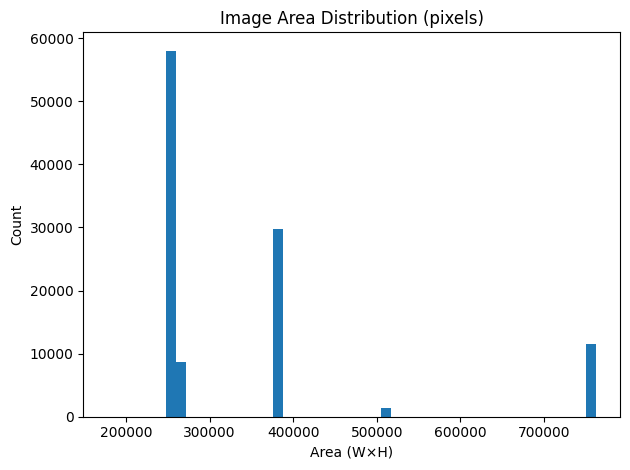

Mean area: 345724
Median area: 253952
Min/Max area: 177834 761856


In [4]:
# Image area distribution
areas = (meta['width'] * meta['height']).astype(int)
plt.figure()
plt.hist(areas, bins=50)
plt.title('Image Area Distribution (pixels)')
plt.xlabel('Area (W×H)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
print("Mean area:", int(areas.mean()))
print("Median area:", int(areas.median()))
print("Min/Max area:", int(areas.min()), int(areas.max()))

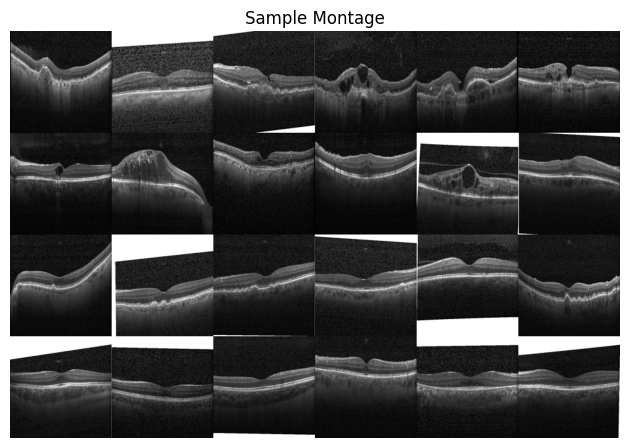

In [5]:
# Build a single-image montage (no subplots): stitch a grid using PIL, then show once.
def build_montage(paths, grid=(4, 6), thumb=(160, 160)):
    cols, rows = grid[1], grid[0]
    W, H = thumb
    canvas = Image.new('L', (cols*W, rows*H), color=0)
    for i, p in enumerate(paths[:rows*cols]):
        try:
            with Image.open(p).convert('L') as im:
                im = im.resize((W, H))
                x = (i % cols) * W
                y = (i // cols) * H
                canvas.paste(im, (x, y))
        except Exception:
            pass
    return canvas

sample_paths = []
per_class = 6
for cls in CLASS_DIRS:
    paths = meta[meta['label_name']==cls]['path'].tolist()
    random.shuffle(paths)
    sample_paths.extend(paths[:per_class])

mont = build_montage(sample_paths, grid=(4, 6), thumb=(160, 160))
plt.figure()
plt.imshow(mont, cmap='gray')
plt.axis('off')
plt.title('Sample Montage')
plt.tight_layout()
plt.show()

In [6]:
# Optional: naive duplicate detection via file hash on a subset
def file_hash(path, block_size=1<<20):
    h = hashlib.md5()
    with open(path, 'rb') as f:
        while True:
            b = f.read(block_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

subset = meta.sample(min(len(meta), 2000), random_state=RNG_SEED).copy()
subset['md5'] = subset['path'].apply(file_hash)
dups = subset[subset.duplicated('md5', keep=False)].sort_values('md5')
print(f"Checked {len(subset)} files; potential duplicates found:", dups['md5'].nunique())
dups.head(10)

Checked 2000 files; potential duplicates found: 2


,patient_id,path,label_name,split,width,height,filesize,label,md5
15780,CNV,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,CNV,train,768,496,75584,0,0ea4e901e39c4940bc2b4e941ef5a681
23256,CNV,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,CNV,train,768,496,75584,0,0ea4e901e39c4940bc2b4e941ef5a681
14529,CNV,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,CNV,train,512,496,52522,0,9dd9861b86abca192dc708ac3d558f9c
9023,CNV,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,CNV,train,512,496,52522,0,9dd9861b86abca192dc708ac3d558f9c


In [7]:
# Export labels.csv for training (image-level). You can later aggregate per patient.
label_to_id = {cls:i for i, cls in enumerate(CLASS_DIRS)}
meta['label'] = meta['label_name'].map(label_to_id)

# Heuristic patient_id from path (customise for your dataset)
from pathlib import Path
def infer_patient_id(p):
    p = Path(p)
    parent = p.parent.name
    stem_digits = ''.join([c for c in p.stem if c.isdigit()]) or 'na'
    return f"{parent}_{stem_digits}"

meta['patient_id'] = meta['path'].apply(infer_patient_id)

labels = meta[['patient_id','path','label','label_name']].copy()
labels.to_csv('labels.csv', index=False)
print('Wrote labels.csv with', len(labels), 'rows')
labels.head()

Wrote labels.csv with 109309 rows


,patient_id,path,label,label_name
0,CNV_5557306155,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,0,CNV
1,CNV_163081153,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,0,CNV
2,CNV_353791228,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,0,CNV
3,CNV_808760823,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,0,CNV
4,CNV_3988971,/Volumes/Extreme SSD/CellData/OCT/train/CNV/CN...,0,CNV


## Next Steps
- Verify `labels.csv` and adjust `patient_id` parsing to your dataset naming.
- Create **patient-level** splits (train/val/test) to avoid leakage.
- Plug `labels.csv` into your PyTorch scaffold (`experiments/exp001_baseline.yaml`).
- Start with a small subset to prove the pipeline, then scale up.

In [8]:
# Export inspection counts and stats

import pandas as pd, json, pathlib

# paths
proj = pathlib.Path.home()/"Documents"/"OCT_Project"
csv_path = proj/"data"/"metadata"/"labels.csv"
out_meta = proj/"data"/"metadata"
out_meta.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(csv_path)

# split x label counts
split_counts = df.groupby(["split","label"]).size().rename("count").reset_index()
split_counts.to_csv(out_meta/"split_counts.csv", index=False)

# overall class counts
class_counts = df.groupby(["label"]).size().rename("count").reset_index()
class_counts.to_csv(out_meta/"class_counts.csv", index=False)

# simple image stats (if your notebook built a DataFrame named `meta` with width/height/filesize)
stats = {}
try:
    meta  # noqa: just checks it exists
    stats = {
        "n_images": int(len(meta)),
        "width_mean": float(meta["width"].mean()),
        "height_mean": float(meta["height"].mean()),
        "filesize_mean": float(meta["filesize"].mean()),
    }
except NameError:
    stats = {"note": "no meta DataFrame with width/height; skipped"}

with open(out_meta/"image_stats.json","w") as f:
    json.dump(stats, f, indent=2)

print("Wrote:", out_meta)

Wrote: /Users/diarmuidlenihan/Documents/OCT_Project/data/metadata
